# An attempt at a bot that trades ETH/USD based on SMA vs EMA

In [1]:
import numpy as np
import json
import requests
import time
import matplotlib.pyplot as plt

## Import JSON data from external source
The price can be found at https://etherchain.org/api/statistics/price


It is in the form: `{'time': '2017-08-09T08:52:45.000Z', 'usd': 303.79}`

In [2]:
#from numpy import genfromtxt
raw_data = np.genfromtxt('btc_usd_bs1hour.csv', delimiter=',')
t=24; # sample rate (samples/day)
raw_data = np.delete(raw_data,0,axis=0) #delete col names
raw_data = np.delete(raw_data,[3,4,5],axis=1) # delete unnecicary rows

## Process data:
The data is then pulled into numpy arrays and the time is parsed as a UNIX Timestamp

In [3]:


data = np.zeros((len(raw_data), 2))
for i in range(0,len(raw_data)):
    hrs_str = str(int(raw_data[i,1]))
    
    while len(hrs_str)<6:
        hrs_str = "0" + hrs_str
    
    time_str = str(int(raw_data[i,0])) + "T" + hrs_str
    time_stamp = int(time.mktime(time.strptime(time_str,'%Y%m%dT%H0000')))
    data[i,0] = time_stamp
    data[i,1] = raw_data[i,2]

## Define Averaging funtions:

These are defined using convolution.

Whether or not the Exponential Moving Average function is correct remains to be seen. It truncates after 3* window length, this is for speed purposes as well as being able to use convolution. 

In [4]:
def moving_avg (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    # Pad with zeros to account for lost data in convolution
    sma = np.concatenate((np.zeros(len(values) - len(sma)),sma),axis=0)
    return sma


def exp_moving_avg (values, window):
    a = 2/(window+1) # EMA Decay rate
    weights = a*np.power((1-a),range(window*3)) # w_{t-i} = a(1-a)^(i)
    ema = np.convolve(values, weights,'valid')
    # Pad with zeros to account for lost data in convolution
    ema = np.concatenate((np.zeros(len(values) - len(ema)),ema),axis=0)
    return ema

## Append Moving Averages to Data:

In [5]:
SMA_days = 0.5 # SMA window length [days]
SMA_5_day = moving_avg(data[:,1], int(SMA_days*t))
## change shape from (x,) to (x,1)
SMA_5_day = SMA_5_day.reshape(len(SMA_5_day), 1)


EMA_days = 1 # EMA window length [days]
EMA_9_day = exp_moving_avg(data[:,1], int(EMA_days*t))
## change shape from (x,) to (x,1)
EMA_9_day = EMA_9_day.reshape(len(EMA_9_day), 1)
##data  = np.concatenate((data, SMA_5_day, EMA_9_day), axis=1)


SMA2_days = 0.75
SMA2 = moving_avg(data[:,1], int(SMA2_days*t))
## change shape from (x,) to (x,1)
SMA2 = SMA2.reshape(len(SMA2), 1)
data  = np.concatenate((data, SMA_5_day, EMA_9_day, SMA2), axis=1)

## Plot a bitch:

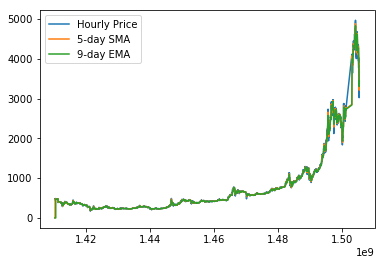

In [6]:
plt.plot(data[:,0],data[:,1], label='Hourly Price')
plt.plot(data[:,0],data[:,2], label='5-day SMA')
plt.plot(data[:,0],data[:,3], label='9-day EMA')
plt.legend()
plt.show()

##### 



## Build a SMA/EMA Trading Bot:

In [9]:
# Enter your initial tradaing params here
eth_bal = 1;
usd_bal = 0;
entry_date = "2015-01-01" #%Y-%m-%d
trading_cost = 0.0025 #0.25% trading costs
slippage = 0 # Time between calling and executing trade (units time)


entry_timestamp = int(time.mktime(time.strptime(entry_date,'%Y-%m-%d')))
eth_equiv_holdings = np.zeros(len(data))
usd_equiv_holdings = np.zeros(len(data))
eth_holdings = np.zeros(len(data))
usd_holdings = np.zeros(len(data))
money_after_trade = 1 - trading_cost
trades_performed = 0;

for i, elem in enumerate(data):
    # Hacky way of skipping over data before purchase time
    if elem[0] < entry_timestamp: 
        continue
    
    #HODL: (BULL/BUY)
    if (elem[2] > elem[3]) and (data[i,4] - data[i-1,4] > 0) and usd_bal != 0:
        eth_bal += usd_bal/data[i+slippage,1] * money_after_trade
        usd_bal = 0;
        trades_performed += 1
    #FUD: (BEAR/SELL)
    elif (elem[2] < elem[3])and (data[i,4] - data[i-1,4] < 0) and eth_bal != 0:
        usd_bal += eth_bal*data[i+slippage,1] * money_after_trade
        eth_bal = 0
        trades_performed += 1
    
#     #HODL: (BULL/BUY)
#     if (data[i,2] - data[i-1,2] > 0) and (data[i,2] - data[i-2,2] > 0) and usd_bal != 0:
#         eth_bal += usd_bal/data[i+slippage,1] * money_after_trade
#         usd_bal = 0;
#         trades_performed += 1
#     #FUD: (BEAR/SELL)
#     elif (data[i,2] - data[i-1,2] < 0) and (data[i,2] - data[i-2,2] < 0) and eth_bal != 0:
#         usd_bal += eth_bal*data[i+slippage,1] * money_after_trade
#         eth_bal = 0
#         trades_performed += 1
    
    # Calculate eth && usd equivalent Holdings:
    if eth_bal == 0:
        eth_equiv_holdings[i] = usd_bal/elem[1]
        usd_equiv_holdings[i] = usd_bal
    else:
        eth_equiv_holdings[i] = eth_bal
        usd_equiv_holdings[i] = eth_bal*elem[1]
    # Store eth and usd actual holdings:
    eth_holdings[i] = eth_bal
    usd_holdings[i] = usd_bal
    
print(trades_performed)
print(money_after_trade**trades_performed)

485
0.29700148036810625


## Plot a comparison between Trading bot && Hodling

In [10]:
%matplotlib
fig, ax1 = plt.subplots()
# ax1 scale is in USD
ax1.plot(data[:,0],data[:,2], label='5-day SMA')
ax1.plot(data[:,0],data[:,3], label='9-day EMA')
ax1.plot(data[:,0],data[:,1], label='Hourly Price')
ax1.plot(data[:,0], usd_equiv_holdings, label='NAV USD')
ax1.plot(data[:,0], usd_holdings, label='USD bal')
# Split axis for ETH scale:
ax2 = ax1.twinx()
ax2.plot(data[:,0], eth_equiv_holdings,'--', label='NAV BTC')
ax2.plot(data[:,0], eth_holdings,'--', label='BTC bal')

ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel("Time Stamp")
ax1.set_ylabel("USD")
ax2.set_ylabel("BTC")

plt.show()

Using matplotlib backend: MacOSX
